データを読み込む

In [134]:
import pandas as pd

In [135]:
use_log = pd.read_csv('./input/03/use_log.csv')
use_log.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [136]:
customer_master = pd.read_csv('./input/03/customer_master.csv')
customer_master.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [137]:
class_master = pd.read_csv('./input/03/class_master.csv')
class_master.head()

,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


In [138]:
campaign_master = pd.read_csv('./input/03/campaign_master.csv')
campaign_master.head()

,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


顧客情報を可視化

In [139]:
customer_join = pd.merge(customer_master, campaign_master, on='campaign_id', how='left')
customer_join = pd.merge(customer_join, class_master, on='class', how='left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,campaign_name,class_name,price
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,通常,オールタイム,10500
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,通常,オールタイム,10500
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,通常,オールタイム,10500
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,通常,オールタイム,10500
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,通常,ナイト,6000


欠損の確認

In [140]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
campaign_name       0
class_name          0
price               0
dtype: int64

`end_date`は退会してない顧客は`NaN`なので欠損値になる

クラス単位で顧客を分類  
可視化を行う

In [141]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
fonts = set([f.name for f in matplotlib.font_manager.fontManager.ttflist])
print(fonts)

{'STIXSizeThreeSym', 'cmsy10', 'DejaVu Sans Mono', 'cmb10', 'STIXSizeFiveSym', 'cmr10', 'DejaVu Serif Display', 'STIXNonUnicode', 'DejaVu Sans', 'STIXSizeOneSym', 'cmmi10', 'cmtt10', 'cmss10', 'STIXSizeTwoSym', 'STIXSizeFourSym', 'STIXGeneral', 'cmex10', 'DejaVu Sans Display', 'DejaVu Serif'}


gender
F    1983
M    2209
Name: customer_id, dtype: int64


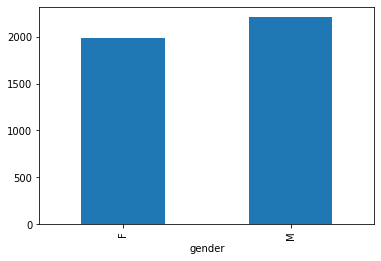

In [142]:

gender_class = customer_join.groupby('gender').count()['customer_id']
print(gender_class)
gender_class.plot.bar()
plt.show()
#sns.histplot(x='class_name', y='customer_id', data=customer_join)

<AxesSubplot:xlabel='gender', ylabel='Count'>

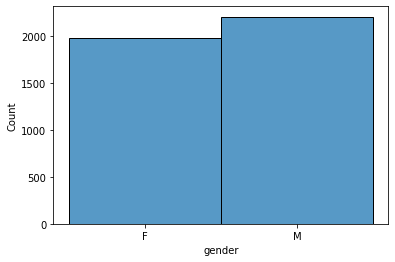

In [143]:
sns.histplot(x='gender', data=customer_join)

In [144]:
customer_join.groupby('is_deleted').count()['customer_id']

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [145]:
customer_join.groupby('class_name').count()['customer_id']

class_name
オールタイム    2045
デイタイム     1019
ナイト       1128
Name: customer_id, dtype: int64

In [146]:
customer_join.groupby('campaign_name').count()['customer_id']

campaign_name
入会費半額     650
入会費無料     492
通常       3050
Name: customer_id, dtype: int64

In [147]:
customer_join.groupby('gender').count()['customer_id']

gender
F    1983
M    2209
Name: customer_id, dtype: int64

最新のユーザ数を集計

In [148]:
customer_join['start_date'] = pd.to_datetime(customer_join['start_date'])
customer_join['end_date'] = pd.to_datetime(customer_join['end_date'])
customer_start = customer_join.loc[customer_join['start_date'] > pd.to_datetime('20180401')]
print(len(customer_start))

1361


In [149]:
customer_join.groupby('end_date').count()['customer_id']

end_date
2018-04-30    121
2018-05-31    125
2018-06-30    106
2018-07-31    102
2018-08-31    113
2018-09-30    104
2018-10-31     90
2018-11-30     89
2018-12-31    111
2019-01-31    129
2019-02-28    149
2019-03-31    111
Name: customer_id, dtype: int64

In [150]:
customer_join.groupby('start_date').count()['customer_id']

start_date
2015-05-01    62
2015-06-01    69
2015-07-01    53
2015-08-01    53
2015-09-01    71
              ..
2019-03-11     3
2019-03-12     8
2019-03-13     4
2019-03-14     4
2019-03-15     1
Name: customer_id, Length: 215, dtype: int64

最新顧客データで集計を行う  
今の顧客データから`2019/3/31`時点に在籍している顧客のみに限定

In [151]:
customer_current = customer_join.loc[(customer_join['end_date'] >= pd.to_datetime('20190331')) | (customer_join['end_date'].isna())]
print(len(customer_current))
customer_current['end_date'].unique()

2953


array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

最新の顧客情報の集計

In [152]:
customer_current.groupby('gender').count()['customer_id']

gender
F    1400
M    1553
Name: customer_id, dtype: int64

In [153]:
customer_current.groupby('campaign_name').count()['customer_id']

campaign_name
入会費半額     311
入会費無料     242
通常       2400
Name: customer_id, dtype: int64

In [154]:
customer_current.groupby('class_name').count()['customer_id']

class_name
オールタイム    1444
デイタイム      696
ナイト        813
Name: customer_id, dtype: int64

利用履歴データを使用する

月別の`平均値`、`中央値`、`最大値`、`最小値`を集計してみる

In [155]:
use_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   log_id       197428 non-null  object
 1   customer_id  197428 non-null  object
 2   usedate      197428 non-null  object
dtypes: object(3)
memory usage: 4.5+ MB


In [156]:
use_log

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01
...,...,...,...
197423,L00000049209753,TS977703,2019-03-31
197424,L00000049209754,TS979550,2019-03-31
197425,L00000049209755,TS995299,2019-03-31
197426,L00000049209756,TS995853,2019-03-31


In [157]:
use_log['usedate'] = pd.to_datetime(use_log['usedate'])
use_log['年月'] = use_log['usedate'].dt.strftime("%Y%m")
use_log_month = use_log.groupby(['年月', 'customer_id'], as_index=False).count()
use_log_month.rename(columns={'log_id':'count'}, inplace=True)
del use_log_month['usedate']
use_log_month.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [158]:
use_log_month

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


ここから顧客毎に月の利用回数の`平均値`、`中央値`、`最大値`、`最小値`を集計する

In [159]:
use_log_customer = use_log_month.groupby('customer_id').agg(['mean', 'median', 'max', 'min'])['count']
use_log_customer.reset_index(drop=False)
use_log_customer.info()
use_log_customer

<class 'pandas.core.frame.DataFrame'>
Index: 4192 entries, AS002855 to TS999855
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    4192 non-null   float64
 1   median  4192 non-null   float64
 2   max     4192 non-null   int64  
 3   min     4192 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 163.8+ KB


,mean,median,max,min
customer_id,,,,
AS002855,4.500000,5.0,7,2
AS008805,4.000000,4.0,8,1
AS009013,2.000000,2.0,2,2
AS009373,5.083333,5.0,7,3
AS015233,7.545455,7.0,11,4
...,...,...,...,...
TS995853,9.500000,9.5,11,8
TS998593,8.142857,8.0,9,7
TS999079,4.916667,5.5,9,2


その顧客が定期利用者かどうかを判断するフラグを作成  
毎週同じ曜日に利用しているかどうかで判断する  
`0`から`6`で、月曜から日曜に対応する

In [160]:
use_log['weekday'] = use_log['usedate'].dt.weekday
use_log_weekday = use_log.groupby(['customer_id', '年月', 'weekday'], as_index=False).count()[['customer_id', '年月', 'weekday', 'log_id']]
use_log_weekday.rename(columns={'log_id':'count'}, inplace=True)

In [161]:
use_log_weekday

,customer_id,年月,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1
...,...,...,...,...
93328,TS999855,201901,1,1
93329,TS999855,201901,5,4
93330,TS999855,201901,6,1
93331,TS999855,201902,5,4


`AS002855`は2018年の4月に土曜日(5)に4回ジムに来ている。5月にも土曜日4回来ている。

In [162]:
use_log_weekday = use_log_weekday.groupby('customer_id', as_index=False).max()[['customer_id', 'count']]
use_log_weekday['routine_flag'] = 0
use_log_weekday['routine_flag'] = use_log_weekday['routine_flag'].where(use_log_weekday['count']<4, 1)

In [163]:
use_log_weekday

,customer_id,count,routine_flag
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1
...,...,...,...
4187,TS995853,5,1
4188,TS998593,5,1
4189,TS999079,5,1
4190,TS999231,5,1


`use_log_weekday`と`use_log_customer`を結合して`customer_join`を作成する

In [164]:
customer_join = pd.merge(customer_join, use_log_weekday, on='customer_id', how='left')
customer_join = pd.merge(customer_join, use_log_customer, on='customer_id', how='left')
customer_join

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,campaign_name,class_name,price,count,routine_flag,mean,median,max,min
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,通常,オールタイム,10500,4,1,4.833333,5.0,8,2
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,通常,オールタイム,10500,5,1,5.083333,5.0,7,3
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,通常,オールタイム,10500,5,1,4.583333,5.0,6,3
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,通常,オールタイム,10500,5,1,4.833333,4.5,7,2
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,通常,ナイト,6000,5,1,3.916667,4.0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaT,CA1,0,通常,オールタイム,10500,3,0,8.000000,8.0,8,8
4188,HD246549,XXXXX,C01,F,2019-03-14,NaT,CA1,0,通常,オールタイム,10500,3,0,10.000000,10.0,10,10
4189,GD037007,XXXXX,C03,M,2019-03-14,NaT,CA1,0,通常,ナイト,6000,2,0,8.000000,8.0,8,8
4190,OA953150,XXXXX,C01,M,2019-03-14,NaT,CA1,0,通常,オールタイム,10500,3,0,11.000000,11.0,11,11


In [165]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
campaign_name       0
class_name          0
price               0
count               0
routine_flag        0
mean                0
median              0
max                 0
min                 0
dtype: int64

会員期間の計算  
まだ退会していない会員は`end_date`が入ってないので、`2019-04-30`として計算する

In [166]:
from dateutil.relativedelta import relativedelta
customer_join['calc_date'] = customer_join['end_date']
customer_join['calc_date'] = customer_join['calc_date'].fillna(pd.to_datetime('20190430'))
customer_join['membership_period'] = 0
for i in range(len(customer_join)):
    delta = relativedelta(customer_join['calc_date'].iloc[i], customer_join['start_date'].iloc[i])
    customer_join['membership_period'].iloc[i] = delta.years*12 + delta.months

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [167]:
customer_join

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,campaign_name,class_name,price,count,routine_flag,mean,median,max,min,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,通常,オールタイム,10500,4,1,4.833333,5.0,8,2,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,通常,オールタイム,10500,5,1,5.083333,5.0,7,3,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,通常,オールタイム,10500,5,1,4.583333,5.0,6,3,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,通常,オールタイム,10500,5,1,4.833333,4.5,7,2,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,通常,ナイト,6000,5,1,3.916667,4.0,6,1,2019-04-30,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaT,CA1,0,通常,オールタイム,10500,3,0,8.000000,8.0,8,8,2019-04-30,1
4188,HD246549,XXXXX,C01,F,2019-03-14,NaT,CA1,0,通常,オールタイム,10500,3,0,10.000000,10.0,10,10,2019-04-30,1
4189,GD037007,XXXXX,C03,M,2019-03-14,NaT,CA1,0,通常,ナイト,6000,2,0,8.000000,8.0,8,8,2019-04-30,1
4190,OA953150,XXXXX,C01,M,2019-03-14,NaT,CA1,0,通常,オールタイム,10500,3,0,11.000000,11.0,11,11,2019-04-30,1


顧客行動の統計量をはかる

In [168]:
customer_join[['mean', 'median', 'max', 'min']].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [169]:
customer_join.groupby('routine_flag').count()['customer_id']

routine_flag
0     779
1    3413
Name: customer_id, dtype: int64

定期的に利用している顧客の方がはるかに多い

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

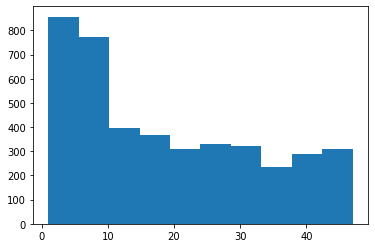

In [171]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.hist(customer_join['membership_period'])

<AxesSubplot:xlabel='membership_period', ylabel='Count'>

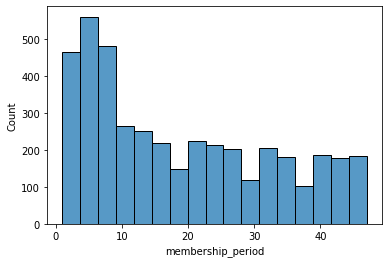

In [172]:
sns.histplot(customer_join['membership_period'])

10ヶ月以下の加入顧客が多く、10ヶ月以上になると横ばいになる。つまり短期で顧客が離れてい行くが、続ける顧客は長く加入していることを示す。

In [174]:
customer_end = customer_join.loc[~customer_join['end_date'].isna()]
customer_end.describe()

,is_deleted,price,count,routine_flag,mean,median,max,min,membership_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.215556,0.456296,3.865474,3.621852,6.461481,1.821481,8.026667
std,0.0,1949.163652,1.217087,0.498271,1.246385,1.270847,2.584021,0.976361,5.033692
min,1.0,6000.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.0,6000.000000,2.000000,0.000000,3.000000,3.000000,4.000000,1.000000,4.000000
50%,1.0,7500.000000,3.000000,0.000000,4.000000,4.000000,7.000000,2.000000,7.000000
75%,1.0,10500.000000,4.000000,1.000000,4.666667,4.500000,8.000000,2.000000,11.000000
max,1.0,10500.000000,5.000000,1.000000,9.000000,9.000000,13.000000,8.000000,23.000000


In [175]:
customer_stay = customer_join.loc[customer_join['end_date'].isna()]
customer_stay.describe()

,is_deleted,price,count,routine_flag,mean,median,max,min,membership_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,4.865588,0.984166,6.030288,6.024279,8.471147,3.620690,23.970443
std,0.0,1977.189779,0.406154,0.124855,1.553587,1.599765,1.571048,2.030488,13.746761
min,0.0,6000.000000,2.000000,0.000000,3.166667,3.000000,5.000000,1.000000,1.000000
25%,0.0,6000.000000,5.000000,1.000000,4.833333,5.000000,7.000000,2.000000,12.000000
50%,0.0,7500.000000,5.000000,1.000000,5.583333,5.500000,8.000000,3.000000,24.000000
75%,0.0,10500.000000,5.000000,1.000000,7.178030,7.000000,10.000000,5.000000,35.000000
max,0.0,10500.000000,5.000000,1.000000,12.000000,12.000000,14.000000,12.000000,47.000000


In [176]:
customer_join.to_csv('./input/03/customer_join.csv', index=False)